## Dependencies

In [1]:
# patch sklearn
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# imports
# standard libraries
import logging
import os
from pathlib import Path
import random
import re
import sys

# third party libraries
import cmasher as cmr
import corner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

# Jupyter display
from IPython.display import Image


In [3]:
# torch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

from torch import nn
from torchinfo import summary
from torchviz import make_dot
import torch.nn.functional as F
import torch.optim as optim


In [4]:
# add local libraries to path
sys.path.append(str(Path.cwd().parents[3] / "src"))

# local libraries
from figures.style import set_style  # noqa: E402
set_style()  # noqa: E402


In [5]:
# find hardware or use cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## 1. Data loading and cleaning

In [6]:
def natural_sort(l: list[str]) -> list[str]:
    """
    Sorts a list of strings naturally (i.e. 1, 2, 3, 10, 11, 12, etc.)

    Parameters
    ----------
    l : list[str]
        List of strings to sort

    Returns
    -------
    list[str]
        Sorted list of strings
    """

    def convert(text: str):
        """
        Converts text to integers if possible. If not, converts to lowercase.

        Parameters
        ----------
        text : str
            Text to convert

        Returns
        -------
        int or str
            Converted text
        """
        if text.isdigit():
            return int(text)
        else:
            return text.lower()

    def alphanum_key(key: str) -> list[str]:
        """
        Splits the key into a list of strings and integers.

        Parameters
        ----------
        key : str
            Key to split

        Returns
        -------
        list[str]
            List of strings and integers
        """
        if not isinstance(key, str):
            key = str(key)
        return [convert(c) for c in re.split("([0-9]+)", key)]

    return sorted(l, key=alphanum_key)


### Parameters

In [7]:
# data source information
n_ca: int = 32
pattern_data: str = "features_2PAcr*.npz"
dir_base: Path = Path("/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/notebooks/polymer_conformation/output/data_generation/data")


### Load data

#### Features data

In [8]:
# find data
files_data: list = natural_sort(list(dir_base.glob(pattern_data)))
print(f"Found {len(files_data)} data files")
print(*files_data, sep="\n")

# pick file with pattern {n_ca}Ca
idx_sim: int = 0
for idx, file in enumerate(files_data):
    if f"{n_ca}Ca" in file.stem:
        idx_sim = idx
        break

# load arrays
print(f"Loading data from {files_data[idx_sim].stem}")
np_data = np.load(files_data[idx_sim])
data = np_data["features_scaled"]
labels = np_data["labels"]

# create dataframes
features = pd.DataFrame(np_data["features_scaled"], columns=np_data["labels"])
features_unscaled = pd.DataFrame(np_data["features"], columns=np_data["labels"])
dynamics = pd.DataFrame({
    "frame": np_data["frames"],
    "time": np_data["times"],
    "weight": np_data["weights"],
})


Found 5 data files
/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/notebooks/polymer_conformation/output/data_generation/data/features_2PAcr-16mer-8Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_5-idx_01.npz
/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/notebooks/polymer_conformation/output/data_generation/data/features_2PAcr-16mer-16Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_5-idx_02.npz
/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/notebooks/polymer_conformation/output/data_generation/data/features_2PAcr-16mer-32Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_6-idx_03.npz
/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/notebooks/polymer_conformation/output/data_generation/data/features_2PAcr-16mer-64Ca-0Na-hremd_wtmetad_prod-12

#### New CV data

In [9]:
# data source information
file_type: str = ["C_alpha_linear", "carboxy_C_linear"]
feats = file_type[0]
pattern_data: str = f"**/contact_matrix_*{feats}.parquet"
dir_base: Path = Path("/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/data/mdanalysis/output_pairdist")

# find data
files_data: list = natural_sort(list(dir_base.glob(pattern_data)))
print(f"Found {len(files_data)} files")

# pick file with pattern {n_ca}Ca
idx_sim: int = 0
for idx, file in enumerate(files_data):
    if f"{n_ca}_Ca" in file.stem:
        idx_sim = idx
        break

print(f"Loading data from {files_data[idx_sim].stem}")

Found 6 files
Loading data from contact_matrix_16_PAcr-32_Ca-C_alpha_and_C_alpha_linear


In [10]:
# load parquet file into dataframe
df_pairdist = pd.read_parquet(files_data[idx_sim])
df_d12 = df_pairdist[["time","frame","d12", "weight"]].copy()


### Clean data

In [11]:
# patterns = []

# drop all columns with pattern "psi_"
# patterns.append("psi_")
# drop columns with pattern "phi_"
# patterns.append("phi_") 

# drop all columns with pattern "CN_Ca_"
# patterns.append("CN_Ca_")
# drop all columns with pattern "CN_Calpha_"
# patterns.append("CN_Calpha_")

# drop columns with pattern "Rg_" or "d12"
# patterns.append("Rg_")
# patterns.append("d12")

# features = features.loc[:, ~features.columns.str.contains("|".join(patterns))]

print(f"Data shape: {features.shape}")
print(f"Remaining features: {features.columns}")


Data shape: (13823, 123)
Remaining features: Index(['CN_Calpha_0', 'CN_Calpha_1', 'CN_Calpha_2', 'CN_Calpha_3',
       'CN_Calpha_4', 'CN_Calpha_5', 'CN_Calpha_6', 'CN_Calpha_7',
       'CN_Calpha_8', 'CN_Calpha_9',
       ...
       'DD_phi_21', 'DD_phi_22', 'DD_phi_23', 'DD_phi_24', 'DD_phi_25',
       'DD_phi_26', 'DD_phi_27', 'Rg_0', 'Rg_1', 'd12'],
      dtype='object', length=123)


In [12]:
print(df_pairdist.filter(regex="ag1_").describe())

       ag1_0_ag2_0    ag1_0_ag2_1    ag1_0_ag2_2    ag1_0_ag2_3  \
count     260475.0  260475.000000  260475.000000  260475.000000   
mean           0.0       2.624895       5.051775       7.097089   
std            0.0       0.053848       0.274082       0.540685   
min            0.0       2.327813       3.335642       3.888059   
25%            0.0       2.588498       4.794373       6.897575   
50%            0.0       2.624707       5.173403       7.071287   
75%            0.0       2.661168       5.244511       7.494177   
max            0.0       2.890584       5.573477       8.202472   

         ag1_0_ag2_4    ag1_0_ag2_5    ag1_0_ag2_6    ag1_0_ag2_7  \
count  260475.000000  260475.000000  260475.000000  260475.000000   
mean        8.780664      10.575323      12.524838      14.281914   
std         0.793365       0.914729       1.201278       1.385106   
min         4.491621       4.750928       5.853328       6.466789   
25%         8.404060      10.057229      11.801818 

In [13]:
# filter out rows where d12 is outside of range
d12_range = (0.69034517, 1.06853427) # FIXME: hard-coded
# d12_range = (0.0, 4.0) # FIXME: hard-coded
df_pairdist = df_pairdist.loc[(df_pairdist["d12"] >= d12_range[0]) & (df_pairdist["d12"] <= d12_range[1])]

# filter columns with pattern "ag1_"
pairdist = df_pairdist.filter(regex="ag1_")
print(f"Loaded {pairdist.shape[0]} rows and {pairdist.shape[1]} columns")
print(f"Columns: {list(pairdist.columns)}")

# make numpy array of shape (n_samples, n_ag1, n_ag2)
n_sample: int = pairdist.shape[0]
n_ag1: int = int(np.sqrt(pairdist.shape[1]))
pairdist_matrix = np.zeros((n_sample, n_ag1, n_ag1))

# reshape each row into a matrix
for idx, row in enumerate(pairdist.values):
    pairdist_matrix[idx] = row.reshape(n_ag1, n_ag1)
print(f"Pairdist matrix shape: {pairdist_matrix.shape}")
print(f"Pairdist matrix 0")

# create array from upper triangular matrix of shape (n_samples, n_ag1 * (n_ag1 - 1) / 2)
pairdist_upper = np.zeros((n_sample, int(n_ag1 * (n_ag1 - 1) / 2)))
for idx, sample in enumerate(pairdist_matrix):
    pairdist_upper[idx] = sample[np.triu_indices(n_ag1, k=1)].flatten()
print(f"Pairdist upper array shape: {pairdist_upper.shape}")


Loaded 13823 rows and 1024 columns
Columns: ['ag1_0_ag2_0', 'ag1_0_ag2_1', 'ag1_0_ag2_2', 'ag1_0_ag2_3', 'ag1_0_ag2_4', 'ag1_0_ag2_5', 'ag1_0_ag2_6', 'ag1_0_ag2_7', 'ag1_0_ag2_8', 'ag1_0_ag2_9', 'ag1_0_ag2_10', 'ag1_0_ag2_11', 'ag1_0_ag2_12', 'ag1_0_ag2_13', 'ag1_0_ag2_14', 'ag1_0_ag2_15', 'ag1_0_ag2_16', 'ag1_0_ag2_17', 'ag1_0_ag2_18', 'ag1_0_ag2_19', 'ag1_0_ag2_20', 'ag1_0_ag2_21', 'ag1_0_ag2_22', 'ag1_0_ag2_23', 'ag1_0_ag2_24', 'ag1_0_ag2_25', 'ag1_0_ag2_26', 'ag1_0_ag2_27', 'ag1_0_ag2_28', 'ag1_0_ag2_29', 'ag1_0_ag2_30', 'ag1_0_ag2_31', 'ag1_1_ag2_0', 'ag1_1_ag2_1', 'ag1_1_ag2_2', 'ag1_1_ag2_3', 'ag1_1_ag2_4', 'ag1_1_ag2_5', 'ag1_1_ag2_6', 'ag1_1_ag2_7', 'ag1_1_ag2_8', 'ag1_1_ag2_9', 'ag1_1_ag2_10', 'ag1_1_ag2_11', 'ag1_1_ag2_12', 'ag1_1_ag2_13', 'ag1_1_ag2_14', 'ag1_1_ag2_15', 'ag1_1_ag2_16', 'ag1_1_ag2_17', 'ag1_1_ag2_18', 'ag1_1_ag2_19', 'ag1_1_ag2_20', 'ag1_1_ag2_21', 'ag1_1_ag2_22', 'ag1_1_ag2_23', 'ag1_1_ag2_24', 'ag1_1_ag2_25', 'ag1_1_ag2_26', 'ag1_1_ag2_27', 'ag1_1_ag2_28',

In [14]:
# verify pairdist matrix is symmetric
for idx, sample in enumerate(pairdist_matrix):
    if not np.allclose(sample, sample.T):
        print(f"Sample {idx} is not symmetric")

# check upper triangular matrix has no zeros or NaNs
if np.any(pairdist_upper == 0):
    print("Pairdist upper array has zeros")

print(f"Pairdist max value: {np.max(pairdist_upper)}")
print(f"Pairdist min value: {np.min(pairdist_upper)}")

Pairdist max value: 38.75443906971155
Pairdist min value: 2.3430728670831744


## 2. Initialize model

### Parameters

In [15]:
# gather data
dataset = pairdist_upper.copy()

In [16]:
# hyper-parameters
percent_train: float = 0.8
seed: int = 42
batch_size: int = 256
num_threads: int = 16
num_epochs: int = 1000
num_epoch_dump: int = 25
num_features: int = dataset.shape[1]

variational: bool = False
verbose: bool = True

learning_rate: float = 1e-3
weight_l2_regular: float = 1e-5
weight_kld_loss: float = 1e0
weight_recons_loss: float = 1e0

dim_latent: int = 2
dim_feature: int = num_features
dim_hidden: list[int] = [num_features, 128, 32]

sample_input = torch.randn(1, dim_feature).to(device).double()
dims = "_".join([str(x) for x in dim_hidden])
tag = (
    f"{feats}-DI_{dim_feature}-DH_{dims}-DL_{dim_latent}"
    + f"-WK_{weight_kld_loss}-WR_{weight_recons_loss}"
    + f"-LR_{learning_rate}-RG_{weight_l2_regular}-BS_{batch_size}-SD_{seed}"
    + f"-VA_{variational}-d12_{d12_range[0]}_{d12_range[1]}"
)


In [17]:
# set random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set data types
torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)

In [18]:
# output directories
dir_out = Path.cwd() / "output_pairdist" / tag

dir_models = dir_out / "models"
dir_figures = dir_out / "figures" 
dir_runs = dir_out / "runs"

for d in [dir_models, dir_figures, dir_runs]:
    d.mkdir(parents=True, exist_ok=True)


### Data set

In [19]:
# normalize data
dataset_min = np.nanmin(dataset)
dataset_max = np.nanmax(dataset)
dataset = (dataset - dataset_min) / (dataset_max - dataset_min)

# verify normalization
assert np.nanmin(dataset) == 0.0
assert np.nanmax(dataset) == 1.0

# verify no NaN/inf
assert not np.isnan(dataset).any()
assert not np.isinf(dataset).any()

# convert to tensor
dataset = torch.from_numpy(dataset)


In [20]:
# split dataset into train and validation sets
train_size = int(percent_train * len(dataset))
test_size = len(dataset) - train_size
train_features, valid_features = random_split(dataset, [train_size, test_size])

# get indices for each set (for plotting)
train_indices = np.array(train_features.indices)
valid_indices = np.array(valid_features.indices)

print(f"Shape of dataset: {dataset.size()}")
print(f"Training set size: {len(train_features)}")
print(f"Validation set size: {len(valid_features)}")

print(f"Training set indices: {train_indices}")


Shape of dataset: torch.Size([13823, 496])
Training set size: 11058
Validation set size: 2765
Training set indices: [13563  1382 10638 ... 13763 10971  6448]


In [21]:
# create dataloaders
kwargs = {"num_workers": num_threads, "batch_size": batch_size, "shuffle": True}
if device == torch.device("cuda"):
    kwargs["pin_memory"] = True

train_loader = DataLoader(train_features, **kwargs)
valid_loader = DataLoader(valid_features, **kwargs)
all_loader = DataLoader(dataset, **kwargs)


### Checks

In [22]:
print(f"Tag: {tag}")
print()
print(f"Number of data points: {len(dataset)}")
print(f"Batch size: {batch_size}")
print()
print(f"Feature dimension: {dim_feature}")
print(f"Hidden dimension: {dim_hidden}")
print(f"Latent dimension: {dim_latent}")


Tag: C_alpha_linear-DI_496-DH_496_128_32-DL_2-WK_1.0-WR_1.0-LR_0.001-RG_1e-05-BS_256-SD_42-VA_False-d12_0.69034517_1.06853427

Number of data points: 13823
Batch size: 256

Feature dimension: 496
Hidden dimension: [496, 128, 32]
Latent dimension: 2


### Neural network architecture

In [23]:
class Autoencoder(nn.Module):

    def __init__(
        self, 
        k_loss_kld: float = 1.0,
        k_loss_recons: float = 1.0,
        input_dim: int = 32,
        latent_dim: int = 2,
        hidden_dims: list[int] = None,
        variational: bool = False,
        verbose: bool = False,
    ):
        super(Autoencoder, self).__init__()
        self.verbose = verbose

        # class logger
        self.logger = logging.getLogger(__name__)
        self.stream_handler = logging.StreamHandler()
        self.formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        )
        self.stream_handler.setFormatter(self.formatter)
        self.logger.addHandler(self.stream_handler)
        self.logger.setLevel(logging.DEBUG if verbose else logging.INFO)

        if hidden_dims is None:
            hidden_dims = [128, 32]

        # layer dimensions
        self.layer_dims = [input_dim] + hidden_dims + [latent_dim]
        self.logger.debug(f"Layer dimensions: {self.layer_dims}")

        # layer functions
        self.layer_func = nn.Linear
        self.activation_func = nn.Tanh
        self.variational = variational

        # build encoder
        modules = []
        if variational:
            self.encoder_dims = [input_dim] + hidden_dims
        else:
            self.encoder_dims = [input_dim] + hidden_dims + [latent_dim]
        self.logger.info(f"Building encoder with {len(self.encoder_dims)} layers of size {self.encoder_dims}")
        for i in range(len(self.encoder_dims) - 1):
            self.logger.debug(f"Adding layer {i}: {self.encoder_dims[i]} -> {self.encoder_dims[i + 1]}")
            modules.append([
                    self.layer_func(self.encoder_dims[i], self.encoder_dims[i + 1], dtype=torch.float64),
                    self.activation_func(),
                ])
        modules = [item for sublist in modules for item in sublist]
        self._encode = nn.Sequential(*modules)
        # initialize weights
        for i in range(len(self._encode)):
            self._encode[i].apply(self._init_weights)

        # build variational (latent) layers
        self.logger.info(f"Building variational layers of dimension ({hidden_dims[-1]}, {latent_dim})")
        self.fc_mu = self.layer_func(hidden_dims[-1], latent_dim, dtype=torch.float64)
        self.fc_var = self.layer_func(hidden_dims[-1], latent_dim, dtype=torch.float64)
        # initialize weights
        self.fc_mu.apply(self._init_weights)
        self.fc_var.apply(self._init_weights)

        # decoder layers: fully connected layers
        self.decoder_dims = [latent_dim] + hidden_dims[::-1] + [input_dim]
        self.logger.info(f"Building decoder with {len(self.decoder_dims)} layers of size {self.decoder_dims}")
        modules = []
        for i in range(len(self.decoder_dims) - 1):
            self.logger.debug(f"Adding layer {i}: {self.decoder_dims[i]} -> {self.decoder_dims[i + 1]}")
            modules.append([
                    self.layer_func(self.decoder_dims[i], self.decoder_dims[i + 1], dtype=torch.float64),
                    self.activation_func(),
            ])
        # add sigmoid activation to last layer
        modules.append([nn.Sigmoid()])
        modules = [item for sublist in modules for item in sublist]
        self._decode = nn.Sequential(*modules)
        # initialize weights
        for i in range(len(self._decode)):
            self._decode[i].apply(self._init_weights)

        # latent space information
        self.z = None
        self.mu = None
        self.logvar = None
        self.sigma = None

        # loss weights
        self.k_loss_kld = k_loss_kld
        self.k_loss_recons = k_loss_recons

        # metrics
        self.loss = 0.
        self.recons_loss = 0.
        self.kld_loss = 0.
        self.kld = 0.

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)
            self.logger.info(f"Initialized weights")
        else:
            self.logger.info(f"Skipped initialization of weights: {module}")
        

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)
        y = torch.empty((self.encoder_dims[-1]), dtype=torch.float64)
        y = self._encode(x)

        if self.variational:
            z = self.reparametrize(y)
        else:
            z = y

        return z

    def bottleneck(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)
        z = self.activation_func(self.fc_mu(x))
        return z
    
    def reparametrize(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = x.to(device)

        # variational layer (latent space)
        self.mu =  self.fc_mu(x)  # mean
        self.logvar = self.fc_var(x)  # log variance
        self.sigma = torch.exp(0.5 * self.logvar)  # standard deviation
        self.epsilon = torch.randn_like(self.sigma) # gaussian noise N(0, 1)
        # kl divergence
        self.kld = self.kl_divergence()

        # reparameterization via sampling from normal distribution
        z = self.mu + self.sigma * self.epsilon
        return z
    
    def kl_divergence(self) -> torch.Tensor:
        if not self.variational:
            return 0.
        return -0.5 * torch.sum(1 + self.logvar - self.mu**2 - torch.exp(self.logvar))

    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        z = z.to(device)
        z = self._decode(z)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat
    
    def loss_function(self, x: torch.Tensor, x_hat: torch.Tensor) \
        -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = x.to(device)
        x_hat = x_hat.to(device)
        
        # reconstruction loss: mean squared error
        self.recons_loss = self.k_loss_recons * F.mse_loss(x_hat, x, reduction="mean")

        # kl divergence loss
        self.kld_loss = self.k_loss_kld * self.kl_divergence() / x.shape[0]

        # total loss
        self.loss = self.recons_loss + self.kld_loss

        return self.loss, self.recons_loss, self.kld_loss
    

### Build model

In [24]:
# create models
model = Autoencoder(
    k_loss_kld=weight_kld_loss,
    k_loss_recons=weight_recons_loss,
    latent_dim=dim_latent,
    input_dim=dim_feature,
    hidden_dims=dim_hidden,
    variational=variational,
    verbose=verbose,
    )
optim = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_l2_regular,
    )

# move to GPU
model = model.to(device)


2023-07-04 08:36:00,226 - __main__ - DEBUG - Layer dimensions: [496, 496, 128, 32, 2]
2023-07-04 08:36:00,227 - __main__ - INFO - Building encoder with 5 layers of size [496, 496, 128, 32, 2]
2023-07-04 08:36:00,227 - __main__ - DEBUG - Adding layer 0: 496 -> 496
2023-07-04 08:36:00,229 - __main__ - DEBUG - Adding layer 1: 496 -> 128
2023-07-04 08:36:00,229 - __main__ - DEBUG - Adding layer 2: 128 -> 32
2023-07-04 08:36:00,230 - __main__ - DEBUG - Adding layer 3: 32 -> 2
2023-07-04 08:36:00,232 - __main__ - INFO - Initialized weights
2023-07-04 08:36:00,232 - __main__ - INFO - Skipped initialization of weights: Tanh()
2023-07-04 08:36:00,233 - __main__ - INFO - Initialized weights
2023-07-04 08:36:00,233 - __main__ - INFO - Skipped initialization of weights: Tanh()
2023-07-04 08:36:00,234 - __main__ - INFO - Initialized weights
2023-07-04 08:36:00,234 - __main__ - INFO - Skipped initialization of weights: Tanh()
2023-07-04 08:36:00,235 - __main__ - INFO - Initialized weights
2023-07-04

### Visualize model

In [25]:
# print summary
fname = f"{dir_models}/model_summary_{tag}.txt"
text = summary(
    model,
    input_size=sample_input.size(),
    device=device.type,
    dtypes=[torch.float64],
)

with open(fname, "w") as f:
    print(text, file=f)

print(text)


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 496]                  132
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 496]                  246,512
│    └─Tanh: 2-2                         [1, 496]                  --
│    └─Linear: 2-3                       [1, 128]                  63,616
│    └─Tanh: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 32]                   4,128
│    └─Tanh: 2-6                         [1, 32]                   --
│    └─Linear: 2-7                       [1, 2]                    66
│    └─Tanh: 2-8                         [1, 2]                    --
├─Sequential: 1-2                        [1, 496]                  --
│    └─Linear: 2-9                       [1, 32]                   96
│    └─Tanh: 2-10                        [1, 32]                   --
│ 

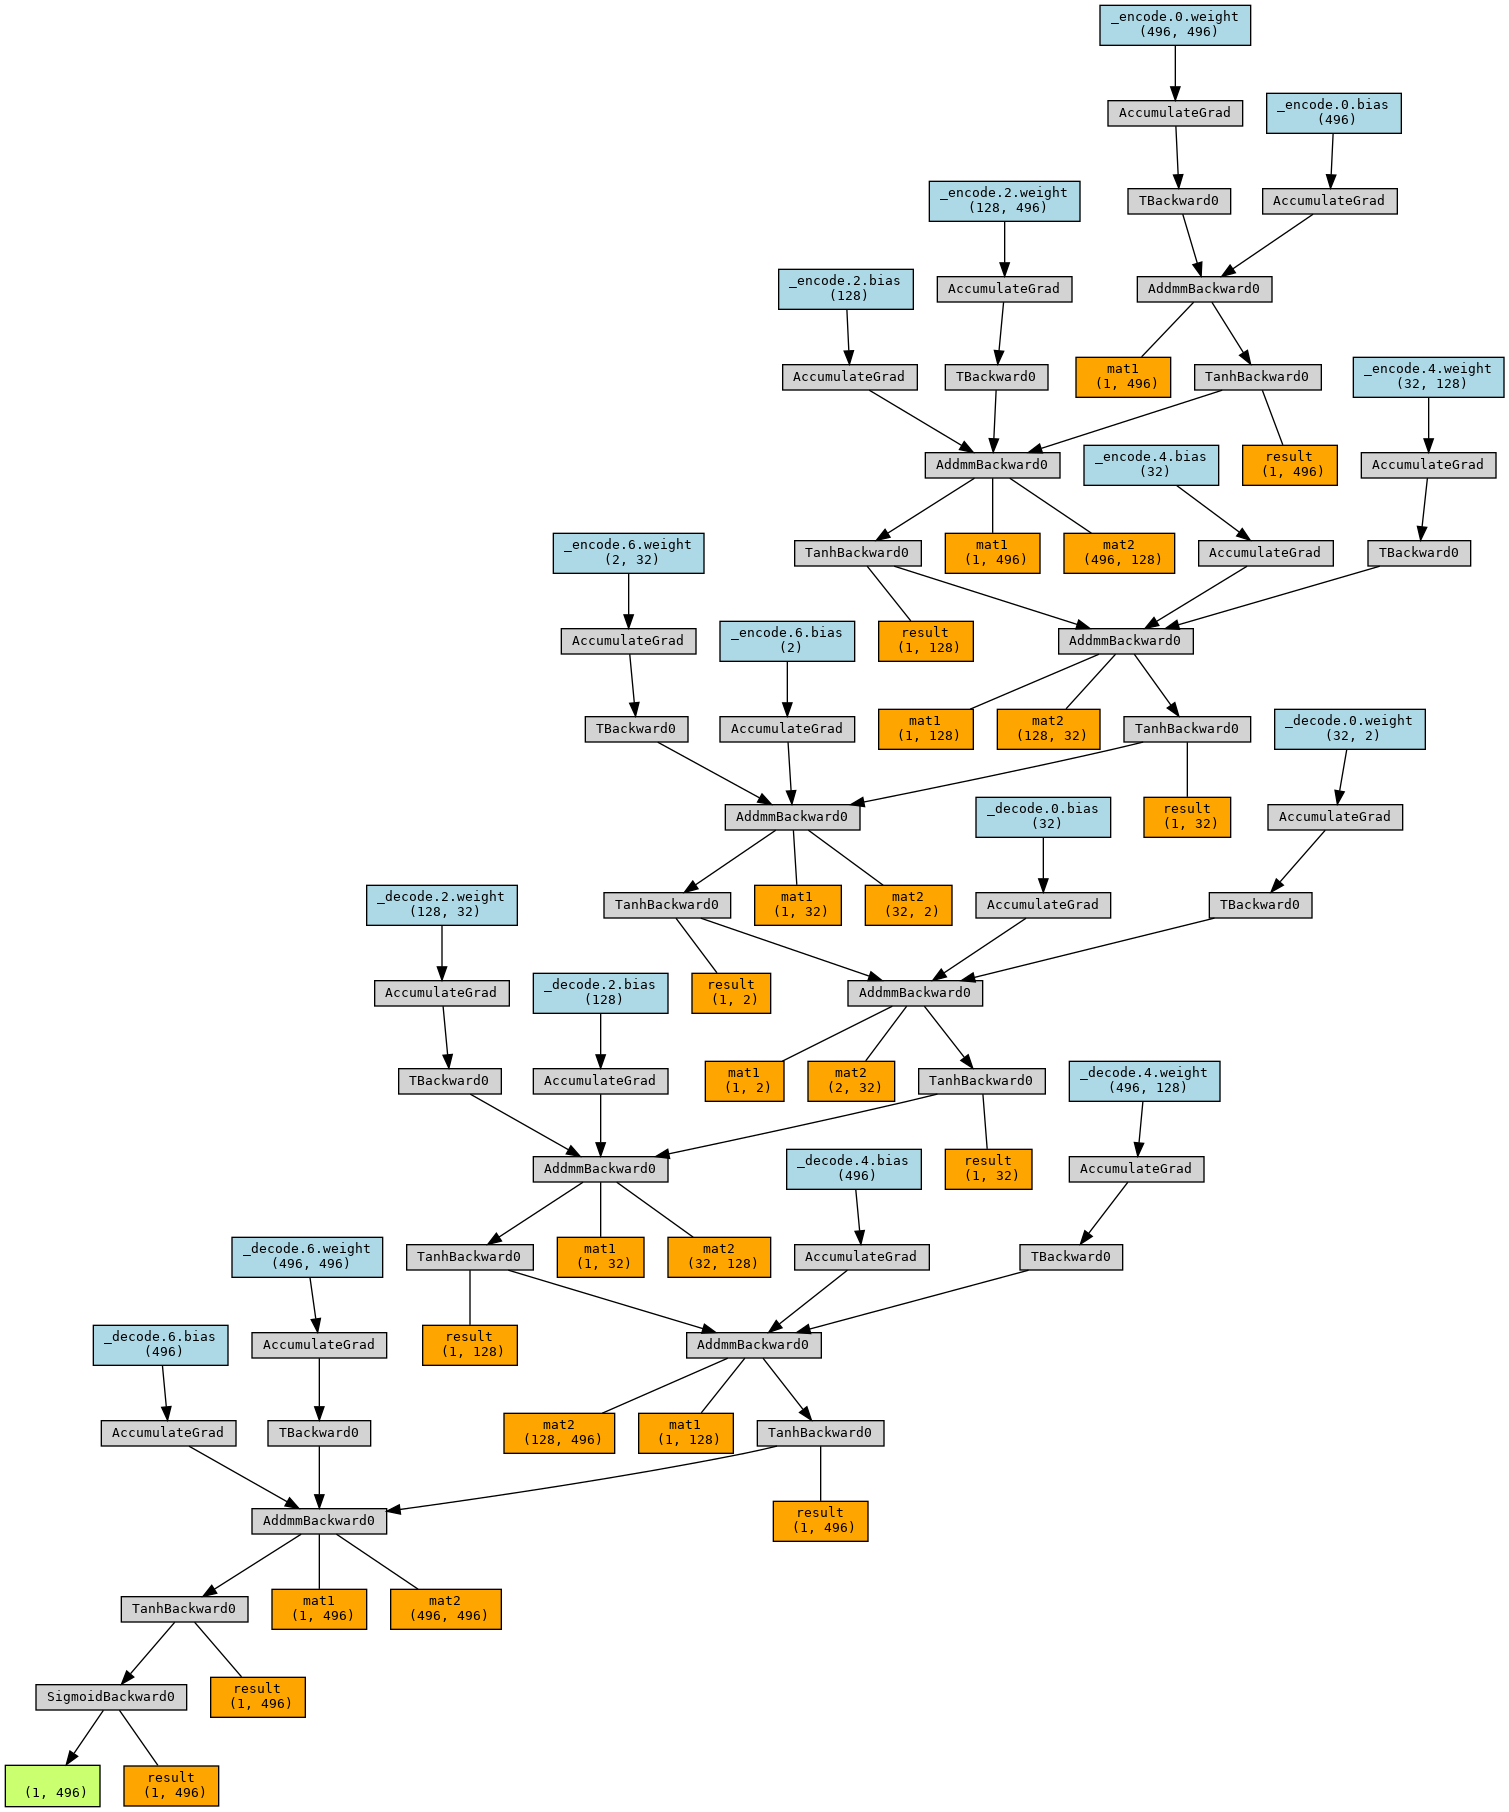

In [26]:
# make image of network
graph = make_dot(
    model(sample_input),
    params=dict(model.named_parameters()),
    show_attrs=False,
    show_saved=True,
)

# save graph
fname = f"{dir_models}/model_network_{tag}"
graph.format = "png"
graph.render(fname)

# delete temporary file
os.remove(f"{fname}")

# show graph
Image(f"{fname}.{graph.format}", width=600)


## 3. Train model

### Helper functions

In [27]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss, recons_loss, kld_loss = 0.0, 0.0, 0.0
    
    # Iterate the dataloader
    for x in dataloader: 
        # Evaluate loss
        x = x.to(device)
        x_hat = vae(x)
        loss, recons, kld = vae.loss_function(x, x_hat)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recons_loss += recons.item()
        if vae.variational:
            kld_loss += kld.item()
    
    # Return loss
    loss = train_loss / len(dataloader.dataset)
    recons_loss = recons_loss / len(dataloader.dataset)
    kld_loss = kld_loss / len(dataloader.dataset)
    return loss, recons_loss, kld_loss


In [28]:
### Testing function
def test_epoch(vae, device, dataloader, verbose=False):
    
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss, recons_loss, kld_loss = 0.0, 0.0, 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            x = x.to(device)
            x_hat = vae(x)
            loss, recons, kld  = vae.loss_function(x, x_hat)
            val_loss += loss.item()
            recons_loss += recons.item()
            if vae.variational:
                kld_loss += kld.item()

        val_loss /= len(dataloader.dataset)
        recons_loss /= len(dataloader.dataset)
        kld_loss /= len(dataloader.dataset)

        if verbose:
                print(f"Loss Validation, Reconstruction, KL: ({val_loss:.4e}, {recons_loss:.4e}, {kld_loss:.4e})")

    return val_loss, recons_loss, kld_loss


In [29]:
def plot_latent(network, data, epoch, tag, perplexity=30, n_iter=300):
    cmap = cmr.take_cmap_colors("cmr.rainforest", 10, cmap_range=(0.1, 0.9))
    fname = f"{dir_figures}/latent-{tag}-epoch_{epoch}"

    # iterate over data loader to get all data
    dat = []
    for i, data in enumerate(data):
        dat.append(data)
    dat = torch.cat(dat)
    z = network.encoder(dat.to(device))
    z = z.to('cpu').detach().numpy()

    # if number of dimensions (columns) is greater than 2, use t-SN
    title = f"Latent Space (Epoch {epoch})"
    if z.shape[1] > 2:
        title = f"Latent Space (Epoch {epoch}; t-SNE)"
        fname += f"-tsne_p{perplexity}_n{n_iter}"
        mod = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
        z = mod.fit_transform(z)
        print(f"Final t-SNE KL divergence: {mod.kl_divergence_:.4f}")
    
    # plot latent space data
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(z[:, 0], z[:, 1], color=cmap[1], alpha=0.7, linestyle="", marker="o", markersize=2)
    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    ax.set_title(title, y=1.02)
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)

    # calculate 2D KDE
    xmin, ymin = z[:, 0].min(), z[:, 1].min()
    xmax, ymax = z[:, 0].max(), z[:, 1].max()
    xx, yy = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([z[:, 0], z[:, 1]])
    kernel = stats.gaussian_kde(values, bw_method=0.04/values.std())
    pdf = kernel(positions).reshape(xx.shape)
    pdf /= pdf.sum()

    # plot latent space PDF
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(
        pdf.T,
        origin="lower",
        aspect="auto",
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9),
    )

    fig.colorbar(im, ax=ax, label=r"Probability Density")
    ax.set_xlabel(f"$t_1$")
    ax.set_ylabel(f"$t_2$")
    ax.set_title("Latent Space", y=1.02)
    fig.tight_layout()
    fig.savefig(f"{fname}_pdf.png", dpi=300)

    # plot fes
    fes = -np.log(pdf)
    fes -= fes.min()
    fig, ax = plt.subplots()
    im = ax.imshow(
        fes.T,
        cmap=cmr.get_sub_cmap("cmr.rainforest_r", 0.1, 0.80),
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
        aspect="auto",
        vmin=0,
        vmax=6,
    )
    # add contours
    levels = [1, 2, 3]
    line_colors = ["white" for l in levels]
    label_colors = ["white" for l in levels]
    cp = ax.contour(xx, yy, fes, levels=levels, colors=line_colors, linewidths=1)
    cl = ax.clabel(cp, fontsize=15, colors=label_colors)
    # add colorbar
    fig.colorbar(im, ax=ax, label=r"$\Delta F$ [$k_{B}\, T$]")
    ax.set_xlabel(f"$t_1$")
    ax.set_ylabel(f"$t_2$")
    ax.set_title("Latent Space", y=1.02)
    fig.tight_layout()
    fig.savefig(f"{fname}_fes.png", dpi=300)


    return fig, ax


In [30]:
def plot_ae_outputs(autoencoder, epoch, tag, n=5):
    
    fig = plt.figure(figsize=(11, 6))
    axs = fig.subplots(3, n+1)
    fname = f"{dir_figures}/ae_outputs-{tag}-epoch_{epoch}"

    fig.suptitle(f"Epoch {epoch}", fontsize=40, fontweight="bold")
    
    for i in range(n):
        img = train_features[i]
        with torch.no_grad():
            rec_img  = autoencoder(img.to(device))
        # convert tensors to 1D numpy arrays
        img_cpu = img.cpu().numpy()
        rec_img_cpu = rec_img.cpu().numpy()

        # pad tensors to be length of perfect square
        num_square = int(np.ceil(np.sqrt(img_cpu.shape[0])))
        num_add = num_square**2 - img_cpu.shape[0]
        img_cpu = np.pad(img_cpu, (0,num_add), mode='constant', constant_values=0)
        rec_img_cpu = np.pad(rec_img_cpu, (0,num_add), mode='constant', constant_values=0)

        # convert 1D arrays to 2d square arrays with 0 for empty space
        img_cpu = np.reshape(img_cpu, (num_square, num_square))
        rec_img_cpu = np.reshape(rec_img_cpu, (num_square, num_square))

        # difference between original and reconstructed
        diff = img_cpu - rec_img_cpu

        # add figures to plot
        im0 = axs[0, i].imshow(diff, cmap=cmr.fusion, vmin=-0.2, vmax=0.2)
        im1 = axs[1, i].imshow(img_cpu, cmap=cmr.lilac, vmin=0, vmax=1)
        im2 = axs[2, i].imshow(rec_img_cpu, cmap=cmr.lilac, vmin=0, vmax=1)

        # plot elements
        titles = ["Difference", "Original", "Reconstructed"]
        for j in range(3):
            ax = axs[j, i]
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n//2:
                ax.set_title(titles[j])
        
        # add colorbar and remove axes on last column
        if i == n-1:
            ims = [im0, im1, im2]
            for j in range(3):
                ax = axs[j, -1]
                ax.axis('off')
                fig.colorbar(ims[j], ax=ax, fraction=0.5, aspect=5)
    
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)
        
    return fig, axs


### Training

In [31]:
# create tensorboard writer
writer = SummaryWriter(dir_runs)
metrics = {
    "epoch": [],
    "Loss/train": [], 
    "Loss/train_recons": [],
    "Loss/train_kld": [],
    "Loss/val": [],
    "Loss/val_recons": [],
    "Loss/val_kld": []
}
fname = f"{dir_models}/vae-{tag}"
print(f"Tag: {tag}")

for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch", total=num_epochs, colour="green"):
    
    # dump outputs
    if epoch % num_epoch_dump == 0:
        print(f"Writing data for epoch {epoch} of {num_epochs}")
        plot_ae_outputs(model, epoch, tag, n=6)
        plot_latent(model, train_loader, epoch, tag)
        torch.save(model.state_dict(), f"{fname}-epoch_{epoch}.pt")
    
    # train and test
    train_loss, train_recons, train_kld = train_epoch(
        vae=model,
        device=device,
        dataloader=train_loader,
        optimizer=optim)
    val_loss, val_recons, val_kld = test_epoch(
        vae=model,
        device=device,
        dataloader=valid_loader, 
        verbose=True)

    # log metrics
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/train_recons", train_recons, epoch)
    writer.add_scalar("Loss/train_kld", train_kld, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Loss/val_recons", val_recons, epoch)
    writer.add_scalar("Loss/val_kld", val_kld, epoch)
    writer.flush()
    metrics["epoch"].append(epoch)
    metrics["Loss/train"].append(train_loss)
    metrics["Loss/train_recons"].append(train_recons)
    metrics["Loss/train_kld"].append(train_kld)
    metrics["Loss/val"].append(val_loss)
    metrics["Loss/val_recons"].append(val_recons)
    metrics["Loss/val_kld"].append(val_kld)

print("Finished Training")
if epoch % num_epoch_dump != 0:
    plot_ae_outputs(model, num_epochs, tag, n=6)
    plot_latent(model, train_loader, num_epochs, tag)

Tag: C_alpha_linear-DI_496-DH_496_128_32-DL_2-WK_1.0-WR_1.0-LR_0.001-RG_1e-05-BS_256-SD_42-VA_False-d12_0.69034517_1.06853427


Epochs:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Writing data for epoch 0 of 1000


/tmp/ipykernel_20171/3941272362.py:61: RuntimeWarning: divide by zero encountered in log
  fes = -np.log(pdf)


Loss Validation, Reconstruction, KL: (5.9388e-05, 5.9388e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (5.8327e-05, 5.8327e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (5.8022e-05, 5.8022e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (5.7965e-05, 5.7965e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.9826e-05, 4.9826e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.8731e-05, 4.8731e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.8690e-05, 4.8690e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.8619e-05, 4.8619e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.8508e-05, 4.8508e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.8351e-05, 4.8351e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.8176e-05, 4.8176e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.7497e-05, 4.7497e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (4.7157e-05, 4.7157e-05, 0.0000e+00)
Loss Validation, Reconstruction, KL: (

In [ ]:
# plot final outputs
plot_ae_outputs(model, num_epochs, tag, n=6)
plot_latent(model, train_loader, num_epochs, tag)

# save model
torch.save(model.state_dict(), f"{fname}-epoch_{num_epochs}.pt")
vae = model

# save indices of all data sets
np.savez_compressed(
    f"{dir_models}/indices-{tag}.npz",
    train=train_indices,
    val=valid_indices
)
data_indices = {"train": train_indices, "val": valid_indices}

## 4. Evaluate model

In [ ]:
# plot the loss curve
fig, ax = plt.subplots()
fname = f"{dir_figures}/loss-{tag}"

ax.plot(range(num_epochs), metrics["Loss/train"], label="Train", linewidth=3)
ax.plot(range(num_epochs), metrics["Loss/val"], label="Validation", linewidth=3)

# convert y-axis to log scale
ax.set_yscale("log")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss Curve", y=1.02)
ax.legend()

fig.tight_layout()
fig.savefig(f"{fname}.png", dpi=300)


In [ ]:
# plot final latent space
n_iter = 10000
perplexities = [5, 10, 20, 30, 50, 80, 100, 200]

for perplexity in perplexities:
    tsne_tag = f"tsne-perplexity_{perplexity}-n_iter_{n_iter}"
    out_tag = f"{tsne_tag}-{tag}"
    fig, ax = plot_latent(vae, all_loader, num_epochs, out_tag, perplexity=perplexity, n_iter=n_iter)
    fig.show()

## 5. Visualize results

In [ ]:
def encode_all(datal: DataLoader, vae: Autoencoder, verbose: bool = False) -> np.ndarray:
    # iterate over data loader to get all data
    dat = []
    for i, data in enumerate(datal):
        dat.append(data)
    dat = torch.cat(dat)
    z = vae.encoder(dat.to(device))
    z = z.to('cpu').detach().numpy()

    if verbose:
        print(f"Data shape: {z.shape}")

    return z


In [ ]:
def fit_tsne(data: np.ndarray, perplexity: int = 30, n_iter: int = 10000, seed: int = 42, verbose: bool = False) -> tuple[np.ndarray, TSNE]:
    # if number of columns is 2, return
    if data.shape[1] == 2:
        return data, None

    # fit t-SNE
    vout = 4 if verbose else 0
    mod = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=n_iter,
        verbose=vout,
        n_jobs=-1,
    )
    z_red = mod.fit_transform(data)
    if verbose:
        print(f"Final t-SNE KL divergence: {mod.kl_divergence_:.4f}")
        print(f"Final t-SNE iterations: {mod.n_iter_+1}")

    return z_red, mod


In [ ]:
# encode all data
z_all = vae.encoder(dataset.to(device)).to('cpu').detach().numpy()
print(f"z_all shape: {z_all.shape}")

In [ ]:
# plot probability distribution of latent space (iterate through each column)
for i, z in enumerate(z_all.T):

    # data analysis
    kernel = stats.gaussian_kde(z)
    z_range = np.linspace(z.min(), z.max(), 1000)
    fes = -np.log(kernel(z_range))
    fes -= np.nanmin(fes)

    # figure
    fname = f"latent-prob-z_{i+1}"
    fig, ax = plt.subplots()
    ax.plot(z_range, fes, linewidth=2.5, label=f"$z_{i+1}$")
    ax.legend(loc="upper right")
    ax.set_xlabel(f"$z$")
    ax.set_ylabel(r"$\Delta F$ [$k_{B}\, T$]")
    ax.set_title("Latent Space", y=1.02)
    fig.tight_layout()
    fig.savefig(f"{dir_figures}/{fname}.png", dpi=300)

It appears that the first and last latent space coordinates explain the most variance

In [ ]:
# access data
n_cols = z_all.shape[1]
bandwidth = 0.05
factor = 1.2
for idx_x in range(n_cols):
    for idx_y in range(idx_x + 1, n_cols):

        x, y = z_all[:, idx_x], z_all[:, idx_y]
        xmin, xmax = np.nanmin(x) * factor, np.nanmax(x) * factor
        ymin, ymax = np.nanmin(y) * factor, np.nanmax(y) * factor

        # calculate 2D KDE
        xx, yy = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values, bw_method=bandwidth/values.std())
        pdf = kernel(positions).reshape(xx.shape)
        pdf /= pdf.sum()

        # figure
        fname = f"latent-pdf-z_{idx_x+1}-z_{idx_y+1}"
        fig, ax = plt.subplots()
        im = ax.imshow(
            pdf.T,
            cmap=cmr.get_sub_cmap("cmr.rainforest", 0.15, 0.96),
            extent=[xmin, xmax, ymin, ymax],
            origin="lower",
            aspect="auto",
        )
        fig.colorbar(im, ax=ax, label=r"Probability Density")
        ax.set_xlabel(f"$z_{idx_x+1}$")
        ax.set_ylabel(f"$z_{idx_y+1}$")
        ax.set_title("Latent Space", y=1.02)
        fig.tight_layout()
        fig.savefig(f"{dir_figures}/{fname}.png", dpi=300)


In [ ]:
# access data
n_cols = z_all.shape[1]
factor = 1.2
bandwidth = 0.05
for idx_x in range(n_cols):
    for idx_y in range(idx_x + 1, n_cols):

        x, y = z_all[:, idx_x], z_all[:, idx_y]
        xmin, xmax = np.nanmin(x) * factor, np.nanmax(x) * factor
        ymin, ymax = np.nanmin(y) * factor, np.nanmax(y) * factor

        # calculate 2D KDE
        xx, yy = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values, bw_method=bandwidth/values.std())
        fes = -np.log(kernel(positions))
        fes -= np.nanmin(fes)
        # convert FES to 2D array
        fes = fes.reshape(xx.shape)

        # # calculate 2D histogram
        # pdf, xx, yy = np.histogram2d(x, y, density=True, bins=100)
        # fes = -np.log(pdf)
        # fes -= np.nanmin(fes)

        # figure
        fname = f"latent-fes-z_{idx_x+1}-z_{idx_y+1}"
        fig, ax = plt.subplots()
        im = ax.imshow(
            fes.T,
            cmap=cmr.get_sub_cmap("cmr.rainforest_r", 0.1, 0.80),
            extent=[xmin, xmax, ymin, ymax],
            origin="lower",
            aspect="auto",
            vmin=0,
            vmax=6,
        )
        # add contours
        levels = [1, 2, 3]
        line_colors = ["white" for l in levels]
        label_colors = ["white" for l in levels]
        cp = ax.contour(xx, yy, fes, levels=levels, colors=line_colors, linewidths=1)
        cl = ax.clabel(cp, fontsize=15, colors=label_colors)
        # add colorbar
        fig.colorbar(im, ax=ax, label=r"$\Delta F$ [$k_{B}\, T$]")
        ax.set_xlabel(f"$z_{idx_x+1}$")
        ax.set_ylabel(f"$z_{idx_y+1}$")
        ax.set_title("Latent Space", y=1.02)
        fig.tight_layout()
        fig.savefig(f"{dir_figures}/{fname}.png", dpi=300)


In [ ]:
ylabels = [f"$z_{i+1}$" for i in range(z_all.shape[1])]
ydata = z_all.copy()
print(f"Shape of Y data: {ydata.shape}")

xcols = [
    "d12",
    "Rg_0",
    "Rg_1"
]
xlabels = [
    r"$r_{12}$",
    r"$R_{g, \, 0}$",
    r"$R_{g, \, 1}$",
    r"$\sum CN{(\mathrm{C}_{\alpha})}$",
    r"$\sum CN{(\mathrm{Ca})}$",
]

xdata = features_unscaled[xcols].values.copy()
# get sum of calpha coordination numbers
cn_calpha = features_unscaled.filter(regex="CN_Calpha").sum(axis=1)
# get sum of calcium coordination numbers
cn_ca = features_unscaled.filter(regex="CN_Ca").sum(axis=1)
# append columns to xdata
xdata = np.hstack([xdata, cn_calpha.values.reshape(-1, 1), cn_ca.values.reshape(-1, 1)])
print(f"Shape of X data: {xdata.shape}")

wdata = dynamics["weight"]
print(f"Shape of W data: {wdata.shape}")

In [ ]:
# plot correlation between latent space and features
figure = corner.corner(
    ydata,
    weights=wdata,
    labels=ylabels,
    quantiles=[0.25, 0.5, 0.75],
    bins=20,
    use_math_text=True,
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
figure.savefig(f"{dir_figures}/corner-latent.png", dpi=300)

In [ ]:
# plot correlation between latent space and features
figure = corner.corner(
    xdata,
    weights=wdata,
    labels=xlabels,
    quantiles=[0.25, 0.5, 0.75],
    bins=20,
    use_math_text=True,
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
figure.savefig(f"{dir_figures}/corner-features.png", dpi=300)

In [ ]:
# plot correlation between latent space and features
dat = np.hstack([ydata, xdata])
labels = ylabels + xlabels

figure = corner.corner(
    dat,
    weights=wdata,
    labels=labels,
    quantiles=[0.25, 0.5, 0.75],
    bins=20,
    use_math_text=True,
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
figure.savefig(f"{dir_figures}/corner-all.png", dpi=300)

In [ ]:
# plot correlation matrix between latent space and features
dat = np.hstack([ydata, xdata])
labels = ylabels + xlabels
df = pd.DataFrame(dat, columns=labels)

# calculate correlation matrix
corr = df.corr()

# plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=cmr.get_sub_cmap("cmr.fusion", 0.1, 0.9),
    vmin=-1,
    vmax=1,
    ax=ax,
)
fig.savefig(f"{dir_figures}/correlation-matrix.png", dpi=300)


## TSNE

In [ ]:
# plot t-SNE colored by third variable
col, col_label = "d12", r"r$_{12}$ [nm]"
cmap = cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9)

for perplexity in perplexities:
    tsne_tag = f"tsne-perplexity_{perplexity}-n_iter_{n_iter}"
    fname = f"{dir_figures}/tsne-{tag}-{tsne_tag}-colored_by_{col}"

    # fit t-SNE using all data
    z_red, mod_tsne = fit_tsne(z_all, perplexity=perplexity, n_iter=n_iter, seed=seed, verbose=False)
    df_t = pd.DataFrame(z_red, columns=["t-SNE 1", "t-SNE 2"])
    df_t.to_parquet(f"{dir_models}/{tsne_tag}-{tag}.parquet")

    # merge all data
    # df = pd.concat([features_unscaled, dynamics], axis=1)
    df_t = pd.concat([df_d12, df_t], axis=1)

    # gather data for plotting
    x, y, z = df_t["t-SNE 1"].copy(), df_t["t-SNE 2"].copy(), df_t[col].copy()
    if col == "d12":
        z /= 10.

    # create figure
    fig, ax = plt.subplots()
    sc = ax.scatter(x, y, c=z, cmap=cmap, s=5)
    fig.colorbar(sc, ax=ax, shrink=0.9, fraction=0.1, pad=0.05, label=col_label)

    # figure elements
    ax.set_xlabel(r"t-SNE 1")
    ax.set_ylabel(r"t-SNE 2")
    ax.set_title(f"t-SNE Colored by {col_label}", y=1.02)

    # save figure
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)
    fig.show()


In [ ]:
# plot t-SNE colored by third variable
col, col_label = "rg_avg", r"$R_g$ [nm]"
cmap = cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9)

for perplexity in perplexities:
    tsne_tag = f"tsne-perplexity_{perplexity}-n_iter_{n_iter}"
    fname = f"{dir_figures}/tsne-{tag}-{tsne_tag}-colored_by_{col}"

    # fit t-SNE using all data
    z_red, mod_tsne = fit_tsne(z_all, perplexity=perplexity, n_iter=n_iter, seed=seed, verbose=False)
    df_t = pd.DataFrame(z_red, columns=["t-SNE 1", "t-SNE 2"])
    df_t.to_parquet(f"{dir_models}/{tsne_tag}-{tag}.parquet")

    # merge all data
    df = pd.concat([features_unscaled, dynamics], axis=1)
    df_t = pd.concat([df, df_t], axis=1)

    # gather data for plotting
    x, y = df_t["t-SNE 1"].copy(), df_t["t-SNE 2"].copy()
    z = (df_t["Rg_0"] + df_t["Rg_1"]) / 2.

    # create figure
    fig, ax = plt.subplots()
    sc = ax.scatter(x, y, c=z, cmap=cmap, s=5)
    fig.colorbar(sc, ax=ax, shrink=0.9, fraction=0.1, pad=0.05, label=col_label)

    # figure elements
    ax.set_xlabel(r"t-SNE 1")
    ax.set_ylabel(r"t-SNE 2")
    ax.set_title(f"t-SNE Colored by {col_label}", y=1.02)

    # save figure
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)
    fig.show()
